In [2]:
!pip install pytorch-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [54]:
!pip install torchmetrics[image]

In [3]:
!pip install torch-fidelity

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from pytorch_fid import fid_score
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import seaborn as sns
from sklearn.manifold import TSNE
import os
# from torchmetrics.image.fid import FrechetInceptionDistance
from torch_fidelity import calculate_metrics
import torch.nn.functional as F

In [6]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
manualSeed = 999
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot = "./data"

# MNIST image size is 28x28, but DCGAN expects at least 32x32, so upscale
image_size = 32

In [7]:
# Data loader
dataset = torchvision.datasets.MNIST(
    root=dataroot,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [34]:
class Generator(nn.Module):
    def __init__(self, nz=100):
        super(Generator, self).__init__()
        # self.nz = nz

        # Modify the generator architecture based on the latent dimension (nz)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 256, 4, 1, 0, bias=False),  # Latent dim nz
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [32]:
# Discriminator Model
ngf = 64  # Generator feature maps
ndf = 64  # Discriminator feature maps
nc = 1    # Number of channels (1 for MNIST)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, 1, 8, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [22]:
# Loss function
criterion = nn.BCELoss()

# Create noise for fixed testing
# fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [37]:
# # Optimizers
# netG = Generator(nz=100).to(device)
# netD = Discriminator().to(device)

# optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Optimizers
# latent_dimensions = [10, 50, 100, 200]  # Different latent dimensions to analyze
latent_dimensions = [10, 50]
fid_scores = []
valid_latents = []

In [24]:
# FID Calculation
def calculate_fid(real_images, fake_images, batch_size=64):
    # InceptionV3 model
    inception_model = models.inception_v3(pretrained=True, transform_input=False)
    inception_model.eval()
    inception_model = inception_model.to(device)

    # Transform to the format required by InceptionV3 (Normalization)
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Prepare datasets
    real_images = DataLoader(real_images, batch_size=batch_size, shuffle=False)
    fake_images = DataLoader(fake_images, batch_size=batch_size, shuffle=False)

    # Get embeddings from InceptionV3 for both real and fake
    def get_features(images):
        features = []
        with torch.no_grad():
            for img in images:
                img = img.to(device)
                img = transform(img).unsqueeze(0)
                feature = inception_model(img)
                features.append(feature)
        return torch.cat(features)

    # Get FID score using pytorch_fid
    fid_value = fid_score.calculate_fid_given_paths(
        real_images, fake_images, batch_size=64, device=device
    )

    return fid_value

In [25]:
# Latent Space Visualization Function
def visualize_latent_space(generator, num_samples=100, latent_dim=100):
    noise = torch.randn(num_samples, latent_dim, 1, 1, device=device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()

    grid = vutils.make_grid(generated_images, nrow=10, padding=2, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [26]:
def save_images_to_folder(images, folder, prefix='img'):
    os.makedirs(folder, exist_ok=True)
    for i, img in enumerate(images):
        vutils.save_image(img, os.path.join(folder, f"{prefix}_{i}.png"), normalize=True)

Training with latent space dimension: 10
[0/5][0/469] Loss_D: 1.4007 Loss_G: 0.9689
[0/5][100/469] Loss_D: 0.9202 Loss_G: 2.0288
[0/5][200/469] Loss_D: 0.9848 Loss_G: 0.7794
[0/5][300/469] Loss_D: 1.0887 Loss_G: 1.7395
[0/5][400/469] Loss_D: 1.2159 Loss_G: 2.0060


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 1920 samples
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "fake_images" with extensions png,jpg,jpeg
Found 1280 samples
Processing samples
Frechet Inception Distance: 75.81333108481351


FID score after epoch 1 with latent space dimension 10: 75.81333108481351
[1/5][0/469] Loss_D: 0.7985 Loss_G: 1.2038
[1/5][100/469] Loss_D: 0.9173 Loss_G: 1.0269
[1/5][200/469] Loss_D: 0.9172 Loss_G: 1.3482
[1/5][300/469] Loss_D: 0.9090 Loss_G: 1.5504
[1/5][400/469] Loss_D: 1.0373 Loss_G: 0.4567


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 1920 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "fake_images" with extensions png,jpg,jpeg
Found 1280 samples
Processing samples
Frechet Inception Distance: 76.1330179064199


FID score after epoch 2 with latent space dimension 10: 76.1330179064199
[2/5][0/469] Loss_D: 0.8692 Loss_G: 0.7469
[2/5][100/469] Loss_D: 0.8379 Loss_G: 1.3872
[2/5][200/469] Loss_D: 0.9519 Loss_G: 1.3424
[2/5][300/469] Loss_D: 1.0366 Loss_G: 1.0397
[2/5][400/469] Loss_D: 0.8688 Loss_G: 0.9427


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 1920 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "fake_images" with extensions png,jpg,jpeg
Found 1280 samples
Processing samples
Frechet Inception Distance: 76.01770622421503


FID score after epoch 3 with latent space dimension 10: 76.01770622421503
[3/5][0/469] Loss_D: 0.8244 Loss_G: 1.5763
[3/5][100/469] Loss_D: 1.0358 Loss_G: 0.7925
[3/5][200/469] Loss_D: 0.8530 Loss_G: 1.8772
[3/5][300/469] Loss_D: 0.8474 Loss_G: 1.9737
[3/5][400/469] Loss_D: 0.7483 Loss_G: 0.9994


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 1920 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "fake_images" with extensions png,jpg,jpeg
Found 1280 samples
Processing samples
Frechet Inception Distance: 76.00027098695804


FID score after epoch 4 with latent space dimension 10: 76.00027098695804
[4/5][0/469] Loss_D: 0.6284 Loss_G: 1.5095
[4/5][100/469] Loss_D: 0.6920 Loss_G: 1.2925
[4/5][200/469] Loss_D: 0.7021 Loss_G: 1.7836
[4/5][300/469] Loss_D: 0.7279 Loss_G: 1.6542
[4/5][400/469] Loss_D: 0.7043 Loss_G: 1.1108


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 1920 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "fake_images" with extensions png,jpg,jpeg
Found 1280 samples
Processing samples
Frechet Inception Distance: 75.74902284984194


FID score after epoch 5 with latent space dimension 10: 75.74902284984194


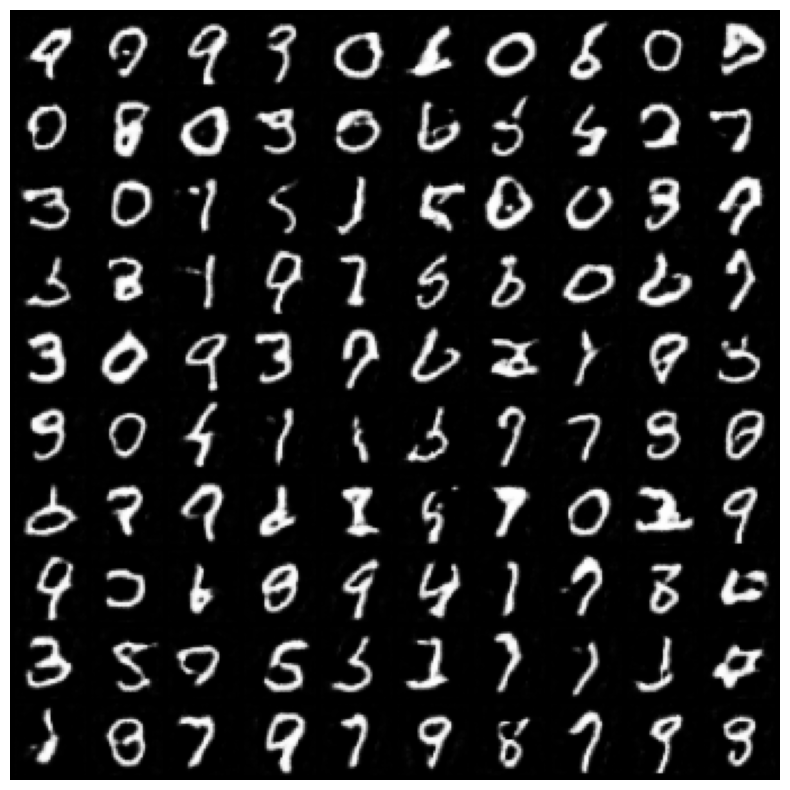

Training with latent space dimension: 50
[0/5][0/469] Loss_D: 1.4040 Loss_G: 0.9356
[0/5][100/469] Loss_D: 0.7445 Loss_G: 2.2433
[0/5][200/469] Loss_D: 0.7941 Loss_G: 1.4518
[0/5][300/469] Loss_D: 0.8074 Loss_G: 1.4462
[0/5][400/469] Loss_D: 0.9373 Loss_G: 2.2707


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 1920 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "fake_images" with extensions png,jpg,jpeg
Found 1280 samples
Processing samples
Frechet Inception Distance: 75.30131010078117


FID score after epoch 1 with latent space dimension 50: 75.30131010078117
[1/5][0/469] Loss_D: 0.5944 Loss_G: 1.7677
[1/5][100/469] Loss_D: 0.6176 Loss_G: 1.4731
[1/5][200/469] Loss_D: 0.6647 Loss_G: 0.9313
[1/5][300/469] Loss_D: 0.7181 Loss_G: 1.3165
[1/5][400/469] Loss_D: 0.6806 Loss_G: 0.9840


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 1920 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "fake_images" with extensions png,jpg,jpeg
Found 1280 samples
Processing samples
Frechet Inception Distance: 75.520468459341


FID score after epoch 2 with latent space dimension 50: 75.520468459341
[2/5][0/469] Loss_D: 0.6220 Loss_G: 1.1436
[2/5][100/469] Loss_D: 0.5909 Loss_G: 1.3535
[2/5][200/469] Loss_D: 0.6442 Loss_G: 1.2485
[2/5][300/469] Loss_D: 0.6470 Loss_G: 1.1951
[2/5][400/469] Loss_D: 0.5704 Loss_G: 1.6017


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 1920 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "fake_images" with extensions png,jpg,jpeg
Found 1280 samples
Processing samples
Frechet Inception Distance: 75.8523282295426


FID score after epoch 3 with latent space dimension 50: 75.8523282295426
[3/5][0/469] Loss_D: 0.8299 Loss_G: 0.6865
[3/5][100/469] Loss_D: 0.6281 Loss_G: 1.6891
[3/5][200/469] Loss_D: 0.8965 Loss_G: 2.2285
[3/5][300/469] Loss_D: 0.6663 Loss_G: 1.2855
[3/5][400/469] Loss_D: 0.5285 Loss_G: 1.6850


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 1920 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "fake_images" with extensions png,jpg,jpeg
Found 1280 samples
Processing samples
Frechet Inception Distance: 75.83039224029602


FID score after epoch 4 with latent space dimension 50: 75.83039224029602
[4/5][0/469] Loss_D: 1.2501 Loss_G: 3.0463
[4/5][100/469] Loss_D: 0.5994 Loss_G: 2.1429
[4/5][200/469] Loss_D: 0.5497 Loss_G: 2.2825
[4/5][300/469] Loss_D: 0.5649 Loss_G: 1.7245
[4/5][400/469] Loss_D: 0.7312 Loss_G: 1.5952


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 1920 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "fake_images" with extensions png,jpg,jpeg
Found 1280 samples
Processing samples
Frechet Inception Distance: 76.31959471936034


FID score after epoch 5 with latent space dimension 50: 76.31959471936034


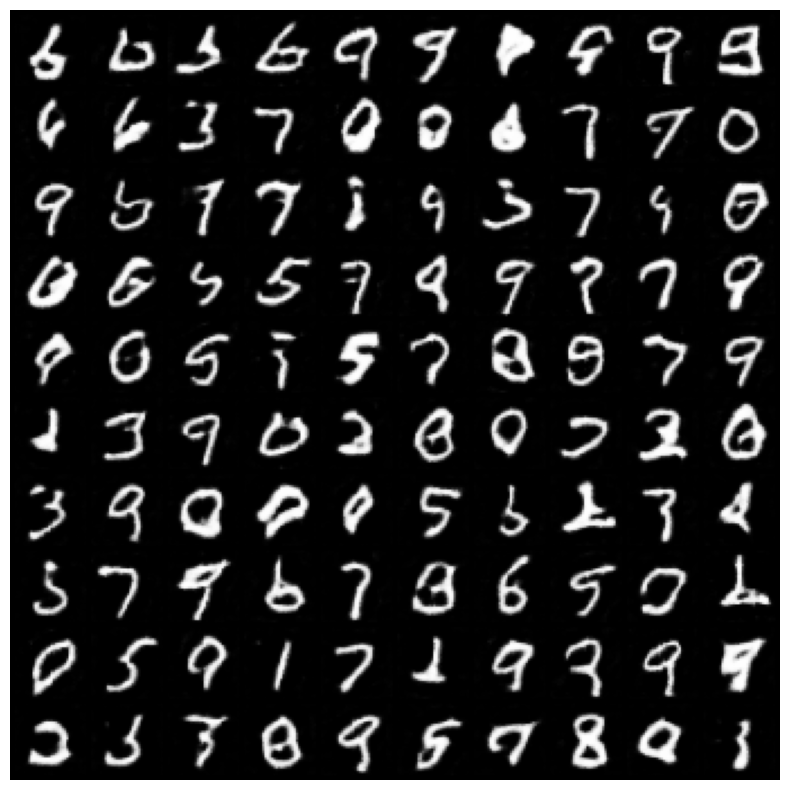

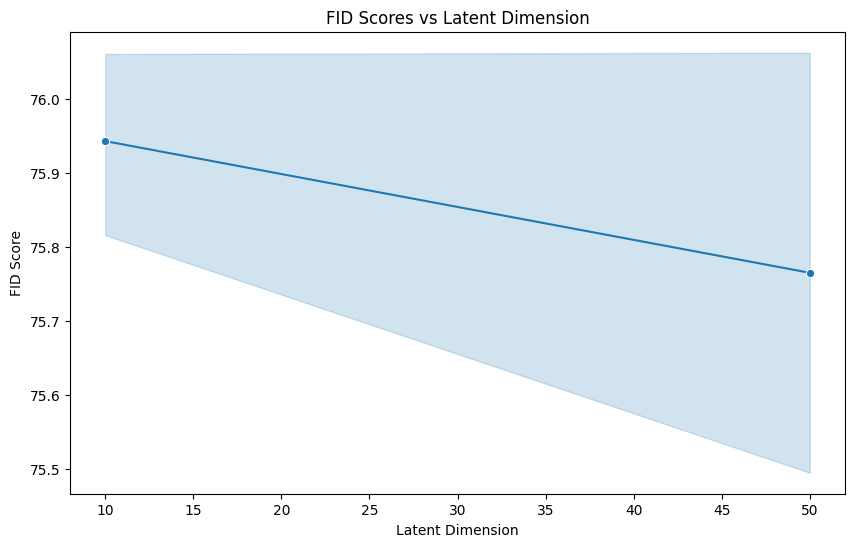

In [38]:
# Latent Dimensionality Analysis
for nz in latent_dimensions:
    print(f"Training with latent space dimension: {nz}")
    netG = Generator(nz=nz).to(device)
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    netD = Discriminator().to(device)

    optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Initialize FID metric (place this here 👇)
    # from torchmetrics.image.fid import FrechetInceptionDistance
    # fid = FrechetInceptionDistance(feature=2048).to(device)

    real_images_list = []
    fake_images_list = []
    epochs = 5
    real_label = 1.
    fake_label = 0.

    for epoch in range(epochs):
        for i, (data, _) in enumerate(dataloader):
            # (1) Update D network
            netD.zero_grad()
            real = data.to(device)
            b_size = real.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

            output = netD(real)
            errD_real = criterion(output, label)
            errD_real.backward()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)

            output = netD(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            optimizerD.step()

            # (2) Update G network
            netG.zero_grad()
            label.fill_(real_label)  # Trick the discriminator

            output = netD(fake)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()

            # (3) FID Accumulation
            # Resize real and fake to 299x299 and scale to [0, 1]
            real_resized = F.interpolate(real, size=(299, 299), mode='bilinear', align_corners=False)
            fake_resized = F.interpolate(fake, size=(299, 299), mode='bilinear', align_corners=False)

            # Optionally scale to [0, 1] if not already (DCGANs often output in [-1, 1])
            real_resized = (real_resized + 1) / 2
            fake_resized = (fake_resized + 1) / 2

            # Collect real images for FID calculation (after each epoch)
            real_images_list.append(real.cpu())

            # Print progress
            if i % 100 == 0:
                print(f'[{epoch}/{epochs}][{i}/{len(dataloader)}] '
                      f'Loss_D: {errD_real + errD_fake:.4f} Loss_G: {errG:.4f}')

        # Save generated images
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            fake_images_list.append(fake)
            save_images_to_folder(fake, 'fake_images', prefix=f'fake_epoch_{epoch}_latent_{nz}')
            save_images_to_folder(real, 'real_images', prefix=f'real_epoch_{epoch}_latent_{nz}')

                # Calculate FID using the custom metric function
        metrics = calculate_metrics(
            input1='real_images',
            input2='fake_images',
            cuda=True,  # set to False if not using GPU
            isc=False,
            kid=False,
            fid=True,
            verbose=True,
        )
        print(f"FID score after epoch {epoch + 1} with latent space dimension {nz}: {metrics['frechet_inception_distance']}")

        # Append FID score for this latent dimension
        fid_scores.append(metrics['frechet_inception_distance'])
        valid_latents.append(nz)

    # Visualize latent space
    visualize_latent_space(netG, num_samples=100, latent_dim=nz)

# Display results of FID for each latent dimension
plt.figure(figsize=(10, 6))
sns.lineplot(x=valid_latents, y=fid_scores, marker='o')
plt.title('FID Scores vs Latent Dimension')
plt.xlabel('Latent Dimension')
plt.ylabel('FID Score')
plt.show()